#### Jupyter notebook to create snapshot maps from WRF output.

James Ruppert  
jruppert@ou.edu  
11/16/23

In [1]:
from netCDF4 import Dataset
import numpy as np
from matplotlib import ticker, colors, rc#, cm
import matplotlib.pyplot as plt
from wrf import to_np, getvar, get_cartopy, interplevel, smooth2d
import cartopy.crs as crs
import cartopy.feature as cfeature
from metpy.plots import ctables
import subprocess

#### Main Settings

In [2]:
#### Directories and model output specs
def get_dims_files(wrf_domain):
    datdir = "/glade/work/ruppert/wrf-piccolo/WRF/run/"
    # datdir = "/glade/derecho/scratch/ruppert/temp/run/"
    process = subprocess.Popen(['ls '+datdir+'wrfout_'+wrf_domain+'_*'],shell=True,
        stdout=subprocess.PIPE,universal_newlines=True)
    output = process.stdout.readlines()
    nt = len(output)
    wrffil_read = Dataset(output[0].strip())
    # lat = wrffil_read.variables['XLAT'] # deg
    # print(lat.shape)
    lat = wrffil_read.variables['XLAT'][:][0] # deg
    lon = wrffil_read.variables['XLONG'][:][0] # deg
    lat1d = lat[:,0]
    lon1d = lon[0,:]
    # nx1 = lat1d.size
    # nx2 = lon1d.size
    nz = wrffil_read.dimensions['bottom_top'].size
    pres = wrffil_read.variables['PB'][0,:,0,0]*1e-2 # Pa --> hPa
    wrffil_read.close()
    return output, nt, lat, lon, nz, pres

wrf_domain="d01"
output, nt, lat, lon, nz, pres = get_dims_files(wrf_domain)

---
### Plotting routines

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

##### Plotting functions

In [4]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, transform, length=None):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, color='black', length=length,
             transform=crs.PlateCarree(), linewidth=1.5)

In [5]:
# Variable settings

def figure_var_specs(plot_name):

    # Switches (default settings)
    i2d=True      # switch on if the data read-in needs to be done in 2D
    dosym=True    # switch off to specify min colorbar setting
    dolog=False   # switch for logarithmic color scale
    extend='both' # extend color fill beyond bounds
    scale=1.      # scale variable by x
    vartag=plot_name

    if plot_name == 'OLR':
        # OLR
        unittag='W m$^{-2}$'
        cmin=75
        cmax=320
        dosym=False
        cmap='RdGy'
    elif plot_name == 'U10':
        # OLR
        unittag='m/s'
        cmin=-10
        cmax=10
        dosym=True
        cmap='RdBu_r'
    elif plot_name == 'MRef':
        # Composite reflectivity (column-max value)
        vartag='mdbz'
        unittag='dBZ'
        cmin=-25
        cmax=60
        dosym=False
        extend='neither'
        # cmap = ctables.registry.get_colortable('NWSReflectivity')#'NWSReflectivityExpanded'
        cmap='Spectral_r'
    elif plot_name == '2mTemp':
        # 2m Temperature
        vartag='T2'
        unittag='K'
        cmin=280
        cmax=310
        dosym=False
        extend='both'
        cmap='RdBu_r'
    elif plot_name == '900-600Thick':
        # p-layer thickness
        unittag='dam'
        cmin=330
        cmax=343
        dosym=False
        extend='both'
        cmap='RdBu_r'

    return vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale

In [6]:
def run_plot(plot_name, plt_area, wrf_domain, it_read):

    vartag, unittag, cmin, cmax, extend, cmap, i2d, dosym, dolog, scale = figure_var_specs(plot_name)

    wrffiles, nt, lat, lon, nz, pres = get_dims_files(wrf_domain)

    title_extra=''

    wrffil_read = Dataset(wrffiles[it_read].strip())
    time = to_np(getvar(wrffil_read, 'Times'))

    if plot_name == '900-600Thick':
        z = getvar(wrffil_read, "z", units="dm")
        p = getvar(wrffil_read, "pres", units="hPa")
        ht_up = interplevel(z, p, 600)
        ht_low = interplevel(z, p, 900)
        thick = ht_up - ht_low
        # pltvar = thick
        pltvar = smooth2d(thick, 6, cenweight=2)
    else:
        pltvar = getvar(wrffil_read, vartag)

    if plot_name == "2mTemp":
        wrffil_read = Dataset(wrffiles[it_read].strip())
        u10 = to_np(getvar(wrffil_read, "U10")) # m/s
        v10 = to_np(getvar(wrffil_read, "V10")) # m/s

    wrffil_read.close()

    hr_tag = str(time)[0:16]

    # if i2d:
    title = plot_name+title_extra+', '+hr_tag
    # else:
    #     title = plot_name+title_extra+', '+hr_tag+',  k-level='+str(ikread)+' (p = '+str(int(pres[ikread]))+' hPa)'

    # Color scale
    nlevs=31#71
    if dosym:
        delta=2*cmax/nlevs
        clevs = np.arange(-1*cmax,cmax+delta,delta)
    else:
        delta=(cmax-cmin)/nlevs
        clevs = np.arange(cmin,cmax+delta,delta)

    # create figure

    fig = plt.figure(figsize=(18,10))
    proj = get_cartopy(pltvar)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(title, fontsize=20)

    # Set plot area
    # ax.set_extent(plt_area)

    # fill contour
    if dolog:
        im = ax.contourf(lon, lat, to_np(pltvar)*scale, cmap=cmap, alpha=0.9,
                            extend='both', zorder=0, norm=colors.LogNorm(vmin=cmin, vmax=cmax),
                            transform=crs.PlateCarree())
        ticks=ticker.LogLocator()
    else:
        im = ax.contourf(lon, lat, to_np(pltvar)*scale, clevs, cmap=cmap, alpha=0.9,
                            extend=extend, zorder=0, transform=crs.PlateCarree())
        ticks=ticker.AutoLocator()

    cbar = plt.colorbar(im, ax=ax, shrink=0.45, ticks=ticks)
    cbar.ax.set_ylabel(unittag)

    # Overlay thickness contours on Updraft Helicity plot
    # if plot_name == "UpHelic":
    #     cont_levs = np.arange(300,400,1)
    #     im = ax.contour(lon, lat, to_np(cont_var)*scale, cont_levs, colors='k', 
    #                         transform=crs.PlateCarree())
    #     ax.clabel(im)

    # Add wind barbs
    if plot_name == "2mTemp" or plot_name == '900-600Thick':
        skip = int(u10.shape[0]/30)
        plot_wind(ax, u10, v10, lon, lat, skip, crs.PlateCarree(), length=6)

    # Add map features
    states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_lines")
    countries = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_0_countries_lakes")
    featurewidth=0.5
    featurecol="black"
    ax.add_feature(states, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    ax.add_feature(countries, linewidth=featurewidth, edgecolor=featurecol, zorder=1)
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # plt.savefig(figdir+plot_name+"_"+hr_tag[0:-3]+".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

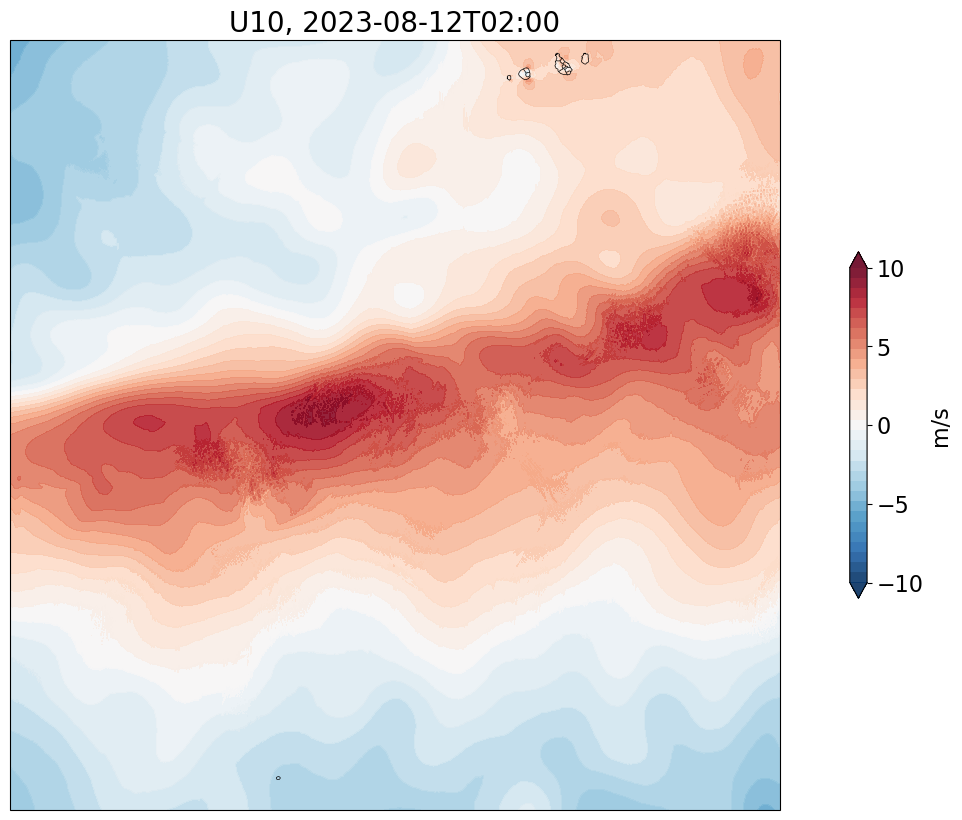

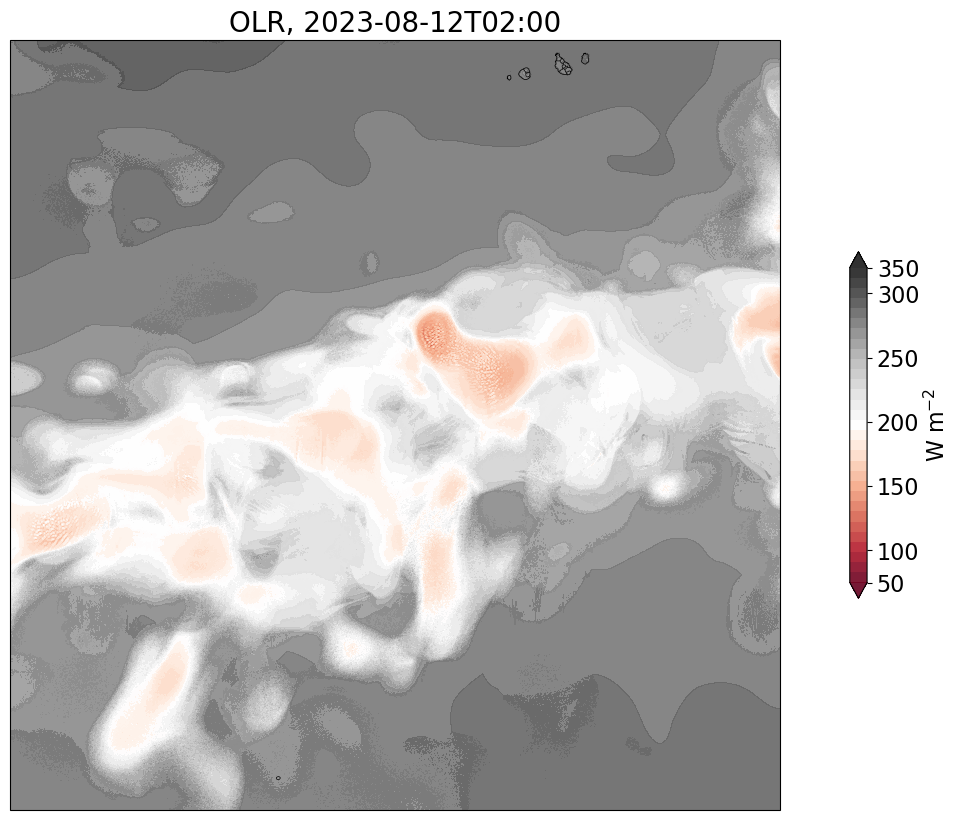

In [10]:
# Plot setup

# wrf_domain="d01"
wrf_domain="d02"

plt_area=[lon[0], lon[-1], lat[0], lat[-1]] # W,E,S,N

it=4

# for var_name in ["OLR", "MRef", "UpHelic", "900-600Thick"]:
# for var_name in ["OLR", "MRef", "900-600Thick"]:
for var_name in ["U10", "OLR"]:
    run_plot(var_name, plt_area, wrf_domain, it)